In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import torch.nn as nn
import torch.optim as optim
from network.gap_layers import *
from datasets.datasets_pair import *
import functools
from network.sym_v1 import *
from network.flownet3d import *
from network.gpv_layers import *
from loss.utils import *
from visu.utils import *
from network.utils import *
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from sklearn.neighbors import NearestNeighbors

In [2]:
root_dir = "/16T/zhangran/GAPartNet_re_rendered/train"
test_intra_dir = "/16T/zhangran/GAPartNet_re_rendered/test_intra"
test_inter_dir = "/16T/zhangran/GAPartNet_re_rendered/test_inter"

In [3]:
dataset_train, dataset_test_intra, dataset_test_inter = get_datasets(root_dir, test_intra_dir, test_inter_dir, voxelization=False, shot=False, choose_category=None, max_points=20000, augmentation=False, with_pose=rotation_matrix_to_euler_angles)
dataloader_train, dataloader_test_intra, dataloader_test_inter = get_dataloaders(dataset_train, dataset_test_intra, dataset_test_inter, num_workers=0, batch_size=8)

In [4]:
from network.GPVNet import *

In [5]:
gpv_net = GPVNet().cuda()
gpv_net.load_state_dict(torch.load("log_dir/GPV_test_new_loss/2024-06-09 13:38:03.887472/GPV_[100|100].pth"))
gpv_net.eval()

GPVNet(
  (backbone): PoseNet9D_Only_R(
    (rot_green): Rot_green(
      (conv1): Conv1d(1280, 1024, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (conv4): Conv1d(256, 4, kernel_size=(1,), stride=(1,))
      (drop1): Dropout(p=0.2, inplace=False)
      (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (rot_red): Rot_red(
      (conv1): Conv1d(1280, 1024, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (conv4): Conv1d(256, 4, kernel_size=(1,), stride=(1,))
      (drop1): Dropout(p=0.2, inplace=False)
      (bn1): BatchNorm1

In [6]:
pc_pairs = next(iter(dataloader_test_inter))
for i in range(len(pc_pairs)):
    pc_pairs[i] = pc_pairs[i].to("cuda:0")
(p_green_R1, p_red_R1, f_green_R1, f_red_R1), (p_green_R2, p_red_R2, f_green_R2, f_red_R2) = gpv_net(pc_pairs)
rot_1_pred = vectors_to_rotation_matrix(p_green_R1, p_red_R1)
rot_2_pred = vectors_to_rotation_matrix(p_green_R2, p_red_R2)

In [24]:
# from network.icp import icp, icp_gpu
import open3d as o3d
import open3d.t.pipelines.registration as treg
from sklearn.neighbors import NearestNeighbors

# Iterative Closest Point, between pc1 :[20000,6] and pc2: [20000,6], 0:3 is position, 3:6 is color
def icp(p1: torch.Tensor, p2: torch.Tensor, cat_with_color=False):
    def process_single_pair(pc1, pc2):
        # 创建Open3D点云对象
        pcd1 = o3d.geometry.PointCloud()
        pcd1.points = o3d.utility.Vector3dVector(pc1)
        
        pcd2 = o3d.geometry.PointCloud()
        pcd2.points = o3d.utility.Vector3dVector(pc2)
        
        # 使用ICP算法进行初步对齐
        threshold = 0.02
        trans_init = np.eye(4)
        reg_p2p = o3d.pipelines.registration.registration_icp(
            pcd1, pcd2, threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint())
        
        # 应用变换矩阵，将pcd2对齐到pcd1
        pcd2.transform(reg_p2p.transformation)
        transformed_pc2 = np.asarray(pcd2.points)
        
        # 使用最近邻搜索找到对应点
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(transformed_pc2)
        distances, indices = nbrs.kneighbors(pc1)
        
        # 计算光流
        flows = transformed_pc2[indices[:, 0]] - pc1
        
        return flows
    
    if p1.ndim == 3 and p2.ndim == 3:
        # 处理三维数据
        batch_size, num_points, _ = p1.shape
        flows_batch = torch.zeros_like(p1)
        
        for i in range(batch_size):
            pc1 = p1[i, :, :3].cpu().numpy()
            pc2 = p2[i, :, :3].cpu().numpy()
            flows = process_single_pair(pc1, pc2)
            flows_tensor = torch.from_numpy(flows).float().to(p1.device)
            flows_batch[i, :, :3] = flows_tensor
            flows_batch[i, :, 3:6] = p1[i, :, 3:6]  # 保持颜色信息
        if cat_with_color:
            return flows_batch
        else:
            return flows_batch[:, :, :3]
    
    elif p1.ndim == 2 and p2.ndim == 2:
        # 处理二维数据
        pc1 = p1[:, :3].cpu().numpy()
        pc2 = p2[:, :3].cpu().numpy()
        flows = process_single_pair(pc1, pc2)
        flows_tensor = torch.from_numpy(flows).float().to(p1.device)
        if cat_with_color:
            flows_tensor = torch.cat((flows_tensor, p1[:, 3:6]), dim=1)  # 保持颜色信息
        
        return flows_tensor
    
    else:
        raise ValueError("Input tensors must be either 2D or 3D with batch dimension.")


def icp_gpu(p1: torch.Tensor, p2: torch.Tensor, cat_with_color=False, voxel_sizes=[0.05, 0.025, 0.0125], max_correspondence_distances=[0.14, 0.07, 0.03], criteria_list=None):
    if criteria_list is None:
        criteria_list = [
            treg.ICPConvergenceCriteria(relative_fitness=0.0001,
                                        relative_rmse=0.0001,
                                        max_iteration=20),
            treg.ICPConvergenceCriteria(0.00001, 0.00001, 15),
            treg.ICPConvergenceCriteria(0.000001, 0.000001, 10)
        ]
    voxel_sizes_vector = o3d.utility.DoubleVector(voxel_sizes)
    max_corr_dist_vector = o3d.utility.DoubleVector(max_correspondence_distances)
    
    def process_single_pair(pc1, pc2):
        # 创建Open3D点云对象
        pcd1 = o3d.t.geometry.PointCloud(o3d.core.Tensor(pc1, o3d.core.Dtype.Float32))
        pcd2 = o3d.t.geometry.PointCloud(o3d.core.Tensor(pc2, o3d.core.Dtype.Float32))

        # 将点云移至CUDA设备
        pcd1_cuda = pcd1.cuda(0)
        pcd2_cuda = pcd2.cuda(0)

        # 初始变换矩阵
        trans_init = o3d.core.Tensor.eye(4, o3d.core.Dtype.Float32)

        # 使用Multi-Scale ICP算法进行对齐
        reg_ms_icp = treg.multi_scale_icp(
            pcd1_cuda, pcd2_cuda,
            voxel_sizes_vector, criteria_list,
            max_corr_dist_vector,
            trans_init,
            treg.TransformationEstimationPointToPoint(),
            # callback_after_iteration=callback_after_iteration
        )

        # 应用变换矩阵，将pcd2对齐到pcd1
        pcd2_cuda.transform(reg_ms_icp.transformation)
        transformed_pc2 = np.asarray(pcd2_cuda.point.positions.cpu().numpy(), dtype=np.float32)

        # 使用最近邻搜索找到对应点
        pc1_tensor = torch.tensor(pc1, dtype=torch.float32).cuda()
        pc2_tensor = torch.tensor(transformed_pc2, dtype=torch.float32).cuda()

        dist = torch.cdist(pc1_tensor, pc2_tensor)
        min_dist, indices = torch.min(dist, dim=1)
        matched_pc2 = pc2_tensor[indices].cpu().numpy()

        # 计算光流
        flows = matched_pc2 - pc1

        return flows
    
    if p1.ndim == 3 and p2.ndim == 3:
        # 处理三维数据
        batch_size, num_points, _ = p1.shape
        flows_batch = torch.zeros_like(p1)

        for i in range(batch_size):
            pc1 = p1[i, :, :3].cpu().numpy()
            pc2 = p2[i, :, :3].cpu().numpy()
            flows = process_single_pair(pc1, pc2)
            flows_tensor = torch.from_numpy(flows).float().to(p1.device)
            flows_batch[i, :, :3] = flows_tensor
            flows_batch[i, :, 3:6] = p1[i, :, 3:6]  # 保持颜色信息
        if cat_with_color:
            return flows_batch
        else:
            return flows_batch[:, :, :3]
    
    elif p1.ndim == 2 and p2.ndim == 2:
        # 处理二维数据
        pc1 = p1[:, :3].cpu().numpy()
        pc2 = p2[:, :3].cpu().numpy()
        flows = process_single_pair(pc1, pc2)
        flows_tensor = torch.from_numpy(flows).float().to(p1.device)
        if cat_with_color:
            flows_tensor = torch.cat((flows_tensor, p1[:, 3:6]), dim=1)  # 保持颜色信息
        
        return flows_tensor
    
    else:
        raise ValueError("Input tensors must be either 2D or 3D with batch dimension.")

def icp_test(pc1, pc2):
    pc1 = pc1.cpu().numpy()
    pc2 = pc2.cpu().numpy()
    pcd1 = o3d.t.geometry.PointCloud(o3d.core.Tensor(pc1, o3d.core.Dtype.Float32))
    pcd2 = o3d.t.geometry.PointCloud(o3d.core.Tensor(pc2, o3d.core.Dtype.Float32))

    # 将点云移至CUDA设备
    pcd1_cuda = pcd1.cuda(0)
    pcd2_cuda = pcd2.cuda(0)
    voxel_sizes = o3d.utility.DoubleVector([0.05, 0.025, 0.0125])

    # List of Convergence-Criteria for Multi-Scale ICP:
    criteria_list = [
        treg.ICPConvergenceCriteria(relative_fitness=0.0001,
                                    relative_rmse=0.0001,
                                    max_iteration=20),
        treg.ICPConvergenceCriteria(0.00001, 0.00001, 15),
        treg.ICPConvergenceCriteria(0.000001, 0.000001, 10)
    ]

    # `max_correspondence_distances` for Multi-Scale ICP (o3d.utility.DoubleVector):
    max_correspondence_distances = o3d.utility.DoubleVector([0.3, 0.14, 0.07])

    # Initial alignment or source to target transform.
    init_source_to_target = o3d.core.Tensor.eye(4, o3d.core.Dtype.Float32)

    # Select the `Estimation Method`, and `Robust Kernel` (for outlier-rejection).
    estimation = treg.TransformationEstimationPointToPoint()

    # Save iteration wise `fitness`, `inlier_rmse`, etc. to analyse and tune result.
    callback_after_iteration = lambda loss_log_map : print("Iteration Index: {}, Scale Index: {}, Scale Iteration Index: {}, Fitness: {}, Inlier RMSE: {},".format(
        loss_log_map["iteration_index"].item(),
        loss_log_map["scale_index"].item(),
        loss_log_map["scale_iteration_index"].item(),
        loss_log_map["fitness"].item(),
        loss_log_map["inlier_rmse"].item()))
    registration_ms_icp = treg.multi_scale_icp(pcd1_cuda, pcd2_cuda, voxel_sizes,
                                           criteria_list,
                                           max_correspondence_distances,
                                           init_source_to_target, estimation,
                                           callback_after_iteration)
    return None
    

In [53]:
import time
import open3d as o3d
import open3d.core as o3c
import open3d.t.pipelines.registration as treg
# 优化时间
def icp_time(p1: torch.Tensor, p2: torch.Tensor, cat_with_color=False):
    start_time = time.time()
    
    def process_single_pair(pc1, pc2):
        step_time = time.time()
        
        # 创建Open3D点云对象
        pcd1 = o3d.geometry.PointCloud()
        pcd1.points = o3d.utility.Vector3dVector(pc1.astype(np.float64)) # use float64, from https://github.com/isl-org/Open3D/issues/1045
        pcd2 = o3d.geometry.PointCloud()
        pcd2.points = o3d.utility.Vector3dVector(pc2.astype(np.float64))
        print("创建点云耗时: {:.4f}秒".format(time.time() - step_time))
        
        step_time = time.time()
        # 使用ICP算法进行初步对齐
        threshold = 0.02
        trans_init = np.eye(4)
        reg_p2p = o3d.pipelines.registration.registration_icp(
            pcd1, pcd2, threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint())
        print("ICP对齐耗时: {:.4f}秒".format(time.time() - step_time))
        
        step_time = time.time()
        # 应用变换矩阵，将pcd2对齐到pcd1
        pcd2.transform(reg_p2p.transformation)
        transformed_pc2 = np.asarray(pcd2.points)
        print("应用变换矩阵耗时: {:.4f}秒".format(time.time() - step_time))
        
        step_time = time.time()
        # 使用最近邻搜索找到对应点
        pc1_tensor = torch.tensor(pc1, dtype=torch.float32).cuda()
        pc2_tensor = torch.tensor(transformed_pc2, dtype=torch.float32).cuda()
        dist = torch.cdist(pc1_tensor, pc2_tensor)
        min_dist, indices = torch.min(dist, dim=1)
        matched_pc2 = pc2_tensor[indices]

        print("最近邻搜索耗时: {:.4f}秒".format(time.time() - step_time))
        
        step_time = time.time()
        # 计算光流
        flows = matched_pc2 - pc1
        print("计算光流耗时: {:.4f}秒".format(time.time() - step_time))
        
        return flows
    
    if p1.ndim == 3 and p2.ndim == 3:
        step_time = time.time()
        # 处理三维数据
        batch_size, num_points, _ = p1.shape
        flows_batch = torch.zeros_like(p1)
        
        for i in range(batch_size):
            pc1 = p1[i, :, :3].cpu().numpy()
            pc2 = p2[i, :, :3].cpu().numpy()
            flows = process_single_pair(pc1, pc2)
            flows_tensor = torch.from_numpy(flows).float().to(p1.device)
            flows_batch[i, :, :3] = flows_tensor
            if cat_with_color:
                flows_batch[i, :, 3:6] = p1[i, :, 3:6]  # 保持颜色信息
        print("处理三维数据耗时: {:.4f}秒".format(time.time() - step_time))
        
        if cat_with_color:
            return flows_batch
        else:
            return flows_batch[:, :, :3]
    
    elif p1.ndim == 2 and p2.ndim == 2:
        step_time = time.time()
        # 处理二维数据
        pc1 = p1[:, :3].cpu().numpy()
        pc2 = p2[:, :3].cpu().numpy()
        flows = process_single_pair(pc1, pc2)
        flows_tensor = torch.from_numpy(flows).float().to(p1.device)
        if cat_with_color:
            flows_tensor = torch.cat((flows_tensor, p1[:, 3:6]), dim=1)  # 保持颜色信息
        print("处理二维数据耗时: {:.4f}秒".format(time.time() - step_time))
        
        return flows_tensor
    
    else:
        raise ValueError("Input tensors must be either 2D or 3D with batch dimension.")
    
def icp_gpu_time(p1: torch.Tensor, p2: torch.Tensor, cat_with_color=False, voxel_sizes=[0.05, 0.025, 0.0125], max_correspondence_distances=[0.14, 0.07, 0.03], criteria_list=None):
    start_time = time.time()
    
    if criteria_list is None:
        criteria_list = [
            treg.ICPConvergenceCriteria(relative_fitness=0.0001,
                                        relative_rmse=0.0001,
                                        max_iteration=20),
            treg.ICPConvergenceCriteria(0.00001, 0.00001, 15),
            treg.ICPConvergenceCriteria(0.000001, 0.000001, 10)
        ]
    voxel_sizes_vector = o3d.utility.DoubleVector(voxel_sizes)
    max_corr_dist_vector = o3d.utility.DoubleVector(max_correspondence_distances)
    
    def process_single_pair(pc1, pc2):
        step_time = time.time()
        
        # 创建Open3D点云对象
        pcd1 = o3d.t.geometry.PointCloud(o3c.Tensor(pc1, o3c.Dtype.Float32))
        pcd2 = o3d.t.geometry.PointCloud(o3c.Tensor(pc2, o3c.Dtype.Float32))
        print("创建点云耗时: {:.4f}秒".format(time.time() - step_time))
        
        step_time = time.time()
        # 将点云移至CUDA设备
        pcd1_cuda = pcd1.cuda(0)
        pcd2_cuda = pcd2.cuda(0)
        print("点云移至CUDA耗时: {:.4f}秒".format(time.time() - step_time))
        
        step_time = time.time()
        # 使用Multi-Scale ICP算法进行对齐
        reg_ms_icp = treg.multi_scale_icp(
            pcd1_cuda, pcd2_cuda,
            voxel_sizes_vector, criteria_list,
            max_corr_dist_vector,
            o3c.Tensor.eye(4, o3c.Dtype.Float32),
            treg.TransformationEstimationPointToPoint(),
        )
        print("Multi-Scale ICP耗时: {:.4f}秒".format(time.time() - step_time))
        
        step_time = time.time()
        # 应用变换矩阵，将pcd2对齐到pcd1
        pcd2_cuda.transform(reg_ms_icp.transformation)
        transformed_pc2 = np.asarray(pcd2_cuda.point.positions.cpu().numpy(), dtype=np.float32)
        print("应用变换矩阵耗时: {:.4f}秒".format(time.time() - step_time))
        
        step_time = time.time()
        # 使用最近邻搜索找到对应点
        pc1_tensor = torch.tensor(pc1, dtype=torch.float32).cuda()
        pc2_tensor = torch.tensor(transformed_pc2, dtype=torch.float32).cuda()
        dist = torch.cdist(pc1_tensor, pc2_tensor)
        min_dist, indices = torch.min(dist, dim=1)
        matched_pc2 = pc2_tensor[indices].cpu().numpy()
        print("最近邻搜索耗时: {:.4f}秒".format(time.time() - step_time))
        
        step_time = time.time()
        # 计算光流
        flows = matched_pc2 - pc1
        print("计算光流耗时: {:.4f}秒".format(time.time() - step_time))
        
        return flows
    
    # 处理三维或二维数据
    if p1.ndim == 3 and p2.ndim == 3:
        step_time = time.time()
        batch_size, num_points, _ = p1.shape
        flows_batch = torch.zeros_like(p1)
        for i in range(batch_size):
            pc1 = p1[i, :, :3].cpu().numpy()
            pc2 = p2[i, :, :3].cpu().numpy()
            flows = process_single_pair(pc1, pc2)
            flows_tensor = torch.from_numpy(flows).float().to(p1.device)
            flows_batch[i, :, :3] = flows_tensor
            if cat_with_color:
                flows_batch[i, :, 3:6] = p1[i, :, 3:6]  # 保持颜色信息
        print("处理三维数据耗时: {:.4f}秒".format(time.time() - step_time))
    elif p1.ndim == 2 and p2.ndim == 2:
        step_time = time.time()
        pc1 = p1[:, :3].cpu().numpy()
        pc2 = p2[:, :3].cpu().numpy()
        flows = process_single_pair(pc1, pc2)
        flows_tensor = torch.from_numpy(flows).float().to(p1.device)
        if cat_with_color:
            flows_tensor = torch.cat((flows_tensor, p1[:, 3:6]), dim=1)  # 保持颜色信息
        print("处理二维数据耗时: {:.4f}秒".format(time.time() - step_time))
    else:
        raise ValueError("Input tensors must be either 2D or 3D with batch dimension.")
    
    print("总耗时: {:.4f}秒".format(time.time() - start_time))
    return flows_batch if p1.ndim == 3 else flows_tensor


In [55]:
input1 = torch.randn(20000,6).cuda()
input2 = torch.randn(20000,6).cuda()
output = icp_time(input1, input2)
output = icp_gpu_time(input1, input2)
print(output.size())

创建点云耗时: 0.0006秒
ICP对齐耗时: 0.0582秒
应用变换矩阵耗时: 0.0005秒
最近邻搜索耗时: 0.0117秒
计算光流耗时: 0.0001秒
处理二维数据耗时: 0.0719秒
创建点云耗时: 0.0002秒
点云移至CUDA耗时: 0.0002秒
Multi-Scale ICP耗时: 0.1023秒
应用变换矩阵耗时: 0.0003秒
最近邻搜索耗时: 0.0116秒
计算光流耗时: 0.0002秒
处理二维数据耗时: 0.1155秒
总耗时: 0.1156秒
torch.Size([20000, 3])


In [6]:
def visu_flows(flow_field: torch.Tensor):
    """
    可视化FlowNet的输出流场。
    
    参数:
    - flow_field: 一个形状为(bs,3,n)的Tensor数组，表示流场，其中n是网格点的数量，bs是Batch size。
    """
    bs = flow_field.size(0)
    n = flow_field.size(2)
    for i in range(bs):
        x = flow_field[i, 0, :].cpu().detach().numpy()
        y = flow_field[i, 1, :].cpu().detach().numpy()
        z = flow_field[i, 2, :].cpu().detach().numpy()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.quiver(x, y, z, x, y, z, length=0.1)
        plt.show()
        if i != 0:
            break # 只显示第一个Batch的结果

# visu_flows(output)

error1:  3.17172888344872
error2:  2.4250163251977006


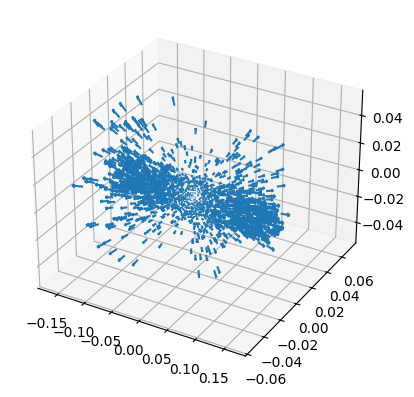

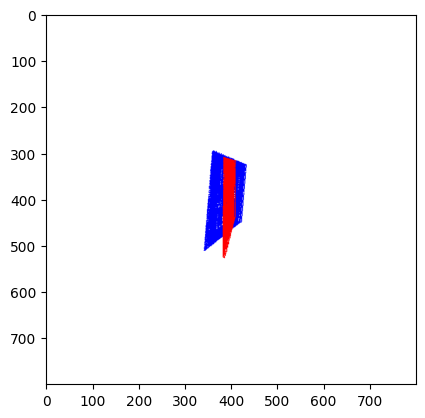

In [46]:
import visu.utils as u
import importlib
importlib.reload(u)
i = None
dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
u.random_show_flow(gpv_net, None, dataset_train, dir_name, use_gt=False, use_icp=True, idx=i,icp_device="cpu")

error1:  5.28637253400704
error2:  3.6148686732661894


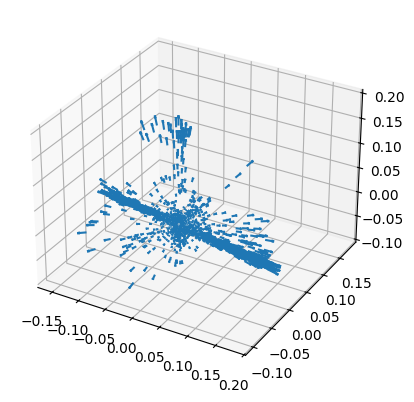

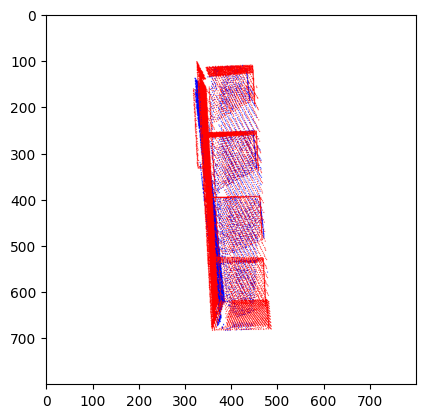

In [17]:
import visu.utils as u
import importlib
importlib.reload(u)
i = None
dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
u.random_show_flow_pc1_to_pc2(gpv_net, None, dataset_train, dir_name, use_gt=False, use_icp=True,idx=i,icp_device="cpu")

In [15]:
# check pair
gpv_net.cpu()
dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
datasets = [dataset_train, dataset_test_inter, dataset_test_intra]
random_check_pair(gpv_net, datasets, dir_name, log_name, transpose=True)

index:  2577
datasets:  /16T/zhangran/GAPartNet_re_rendered/train
Box_100676_0_6  and  Box_100676_0_7
rot1:  tensor([[[ 0.4592, -0.8972, -0.0603],
         [-0.7277, -0.3186, -0.5976],
         [ 0.5095,  0.3059, -0.7992]]])
gt1:  tensor([[[ 4.2010e-01, -9.0748e-01,  5.9605e-08],
         [-6.6982e-01, -3.1008e-01, -6.7468e-01],
         [ 6.1225e-01,  2.8343e-01, -7.3811e-01]]])
vectors1:  tensor([[-0.8972, -0.3186,  0.3059]]) tensor([[ 0.4592, -0.7277,  0.5095]])
vectors_gt1:  tensor([[-0.9075, -0.3101,  0.2834]]) tensor([[ 0.4201, -0.6698,  0.6123]])
error1:  2.6484712124065943
error_gt:  0.0
rot2:  tensor([[[ 0.4084, -0.6276, -0.0969],
         [-0.5185, -0.3508, -0.7553],
         [ 0.7512,  0.6951, -0.4687]]])
gt2:  tensor([[[ 7.7618e-01, -6.3051e-01, -2.9802e-08],
         [-2.7930e-01, -3.4383e-01, -8.9654e-01],
         [ 5.6527e-01,  6.9588e-01, -4.4297e-01]]])
vectors2:  tensor([[-0.6276, -0.3508,  0.6951]]) tensor([[ 0.4084, -0.5185,  0.7512]])
vectors_gt2:  tensor([[-0.630